In [1]:
###In this version I will calculate ALL features and put them in a single dataframe
#THEN loop through the dataframe of features to see wag1 in classification

In [1]:
import time
t1 = time.time()

In [2]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

## Use decision tree as a rough way for splitting based on that feature
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn import tree

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Load the PSD Data and take a single region (Central)

In [3]:
data_type = 'N1'
df = joblib.load(os.path.join(os.path.abspath('..'), data_type + '_psd_normalised_data.pkl') )

single_region_df = df[[col for col in df.columns if col.endswith('_Central')]]
frequency_vals  = np.arange(0.5,40.125, 0.125)
single_region_df.columns = frequency_vals

folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
paths = joblib.load(folder + data_type + '_paths.pkl')

groups = pd.Series(paths['s_p_id'])
s_class_list = pd.Series(paths['s_class_list'])
y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3})

In [4]:
width_slide_list = [(0.5,0.5)] 
for window_width in range(1, 15 ):
    width_slide_list.append((window_width, 0.5) )

### Set the window width in hz and window slide in hz

In [5]:
t3 = time.time()

results_dfs = []
feature_dfs = []

j = 0 #counter to populate feature dict dataframes

for window_width_hz, window_slide_hz in width_slide_list:
    description = 'window width : ' + str(window_width_hz) + ' .  window stride : ' + str(window_slide_hz)
    
    #1.Set Window width in Hz and Window Slide in Hz
    # window_width_hz = 3
    window_len = (window_width_hz/0.125)+1
    assert window_len%1 == 0
    window_len = int(window_len)
    
    # window_slide_hz = 0.5 
    window_slide_len = window_slide_hz/0.125 
    assert window_slide_len%1 == 0
    window_slide_len = int(window_slide_len)
    
    
    #2.Calculate band values and store in dataframe calculated_df
    
    # Start of the window is the middle_freq value minus window_width_hz/2 
    # End of the window is the middle freq value plus window_width_hz/2
    window_len
    
    middle_freq = []
    final_cols = []
    
    i = 0
    while i < len(frequency_vals) - window_len:
        middle_freq.append( frequency_vals[i:i+window_len].mean() )
        band_vals = single_region_df.iloc[:,i:i+window_len].mean(axis = 1) #For every row calculate the mean for the appropriate elements
        
        final_cols.append(band_vals)
        
        # scaled_psd.append( psd_values[i:i+factor].mean() )
        i+= window_slide_len
    
    calculated_df = pd.DataFrame(final_cols).T
    calculated_df.columns = middle_freq
    
    calculated_df.columns = [ str(col) + '_width_' + str(window_width_hz) for col in calculated_df.columns]
    
    
    #3.Calculate Information Gain Based on Features
    #Change to binary HC vs PD / PD+RBD ---> Generate expt specific X,y,groups 
    expt_num = 1
    X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(calculated_df,y,groups,expt_num)

    feature_dfs.append(X_expt)
        
t4 = time.time()
t4-t3

0.6458842754364014

In [14]:
X_expt_concatenated = pd.concat(feature_dfs, axis=1)
y_expt 

cols_list = list(X_expt_concatenated.columns)

col_combos = []

for col_1 in cols_list:
    for col_2 in cols_list:
        col_combos.append([ col_1 , col_2 ] )
        

In [122]:
from math import comb


473851

In [126]:
comb(974, 3)

153527724

In [127]:
153527724 / 1000000

153.527724

In [125]:
 ( (473851 / 100000)*237 ) / 60

18.717114499999997

In [123]:
len(col_combos)/ comb(974, 2)

2.0020554984583763

In [120]:
len(cols_list)

974

#### Reduce redundancy in col_combos list

In [117]:
col_combos_2 = []
for col_1 in cols_list:
    ind = cols_list.index(col_1)
    for col_2 in cols_list[ind+1:]:
        col_combos_2.append([ col_1 , col_2 ] )

In [119]:
len(col_combos_2)

473851

In [111]:
974*974

948676

#### Fit models using the column combos

In [19]:
from sklearn.linear_model import RidgeClassifier

In [52]:
X_selected = X_expt_concatenated[ ['10.0_width_4','2.25_width_0.5'] ]
clf = RidgeClassifier(alpha = 0.001).fit(X_selected, y_expt)
score = accuracy_score(y_expt,  clf.predict(X_selected))
score

0.625

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [56]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_selected, y_expt)
accuracy_score( clf.predict(X_selected) , y_expt)

0.75

100,000 took four minutes

In [84]:
t1 = time.time()

scores = []
for col_combo in col_combos[:100000] : 
    X_selected = X_expt_concatenated[ col_combo ]
    # clf = RidgeClassifier().fit(X_selected, y_expt)
    clf = LinearDiscriminantAnalysis().fit(X_selected, y_expt)
    score = accuracy_score(y_expt,  clf.predict(X_selected))
    scores.append(score)

t2 = time.time()

t2-t1

236.6117582321167

In [97]:
np.array(scores).max()

0.875

In [107]:
scores[30569]

0.875

In [108]:
col_combos[30569]

['16.25_width_0.5', '3.5_width_5']

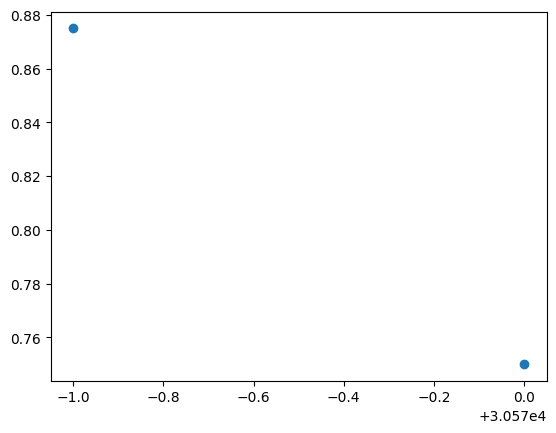

In [106]:
start = 30569 
end = 30571
plt.scatter([i for i in range(len(scores))][start:end], scores[start:end])

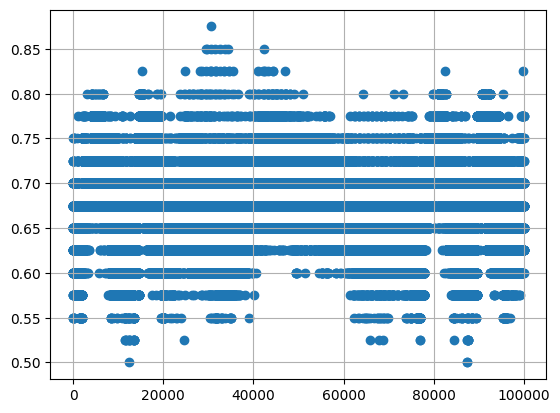

In [98]:
plt.scatter([i for i in range(len(scores))], scores)
plt.grid()

#### Do a plot based on the best two features to see how good they are

In [68]:
#Decent for N1 plt.scatter(feats_dict[3][1]['4.0_width_2'], feats_dict[4][1]['2.5_width_3'] , c = y_expt.values )

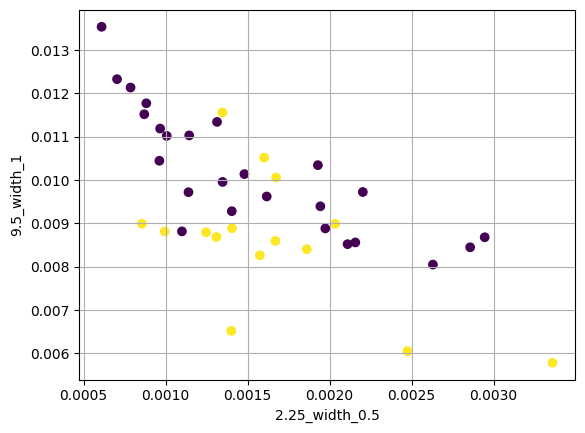

In [109]:
plt.scatter(X_expt_concatenated['16.25_width_0.5'], X_expt_concatenated['3.5_width_5'] , c = y_expt.values )
plt.xlabel('2.25_width_0.5')
plt.ylabel('9.5_width_1')
plt.grid()

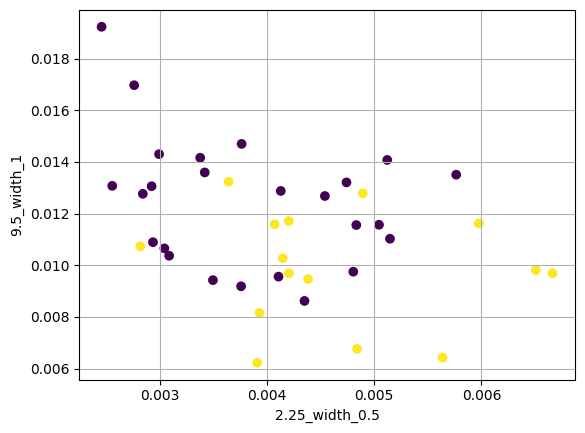

In [83]:
plt.scatter(X_expt_concatenated['10.0_width_4'], X_expt_concatenated['2.25_width_0.5'] , c = y_expt.values )
plt.xlabel('2.25_width_0.5')
plt.ylabel('9.5_width_1')
plt.grid()

https://stackoverflow.com/questions/4739360/any-easy-way-to-plot-a-3d-scatter-in-python-that-i-can-rotate-around